In [1]:
import pandas
#pip install praw
import praw
#pip install nltk
import nltk
import numpy as np

positive = pandas.read_csv("./db/comments_positive_reduced.csv")
negative = pandas.read_csv("./db/comments_negative_reduced.csv")
positive.tail(50)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality
199950,cpadbxx,t1_cpad94e,t5_2qmg3,t3_2ykl0b,Aww come on. He actually wants a ring.,385,385,Jabbajaw,0,t3_2ykl0b,boo this man,208.0,208.0,ysw_,0.0
199951,c6ho212,t1_c6hnzz5,t5_2qh1i,t3_10y8i7,"*Hey mister, you need to wash your eyeballs!*\...",385,385,REallyDiDntdoIT,0,t3_10y8i7,Only because it's true!,205.0,205.0,MadeInDeutschland,0.0
199952,c5ybvkh,t1_c5y98kz,t5_2qh0u,t3_yruni,I was hoping for a picture of piss. Then I rea...,385,385,myusernamebarelyfits,0,t3_yruni,and after you drink it....\nhttp://i.imgur.com...,450.0,450.0,Brumeh,0.0
199953,c4fkqqq,t1_c4fk5l1,t5_2qh0u,t3_so2tz,"nice try, pocket sized fascist warlord.",385,385,PseudoChemist,0,t3_so2tz,"If I needed something built, I would definitel...",479.0,479.0,surprisedpanda,0.0
199954,c46gwxa,t1_c46egli,t5_2qh1i,t3_rjobx,"As your hand, I can confirm this.\n\nShit's good.",385,385,Can_Confirm_This,0,t3_rjobx,I enjoyed my dick years before anyone else gre...,841.0,841.0,Tnwagn,0.0
199955,c49qg97,t1_c49puny,t5_2qh61,t3_ryg2j,So just because I'm dating someone I'm suppose...,385,385,frostysauce,0,t3_ryg2j,It's to discourage room sharing between non-co...,755.0,755.0,checksumfail,0.0
199956,cphumyf,t1_cphtfhj,t5_2qo4s,t3_2zd4q3,"""So why you always in here checking out dudes ...",385,385,vforprez2,0,t3_2zd4q3,"This is pretty common. On his radio show, Marc...",150.0,150.0,paulz0rs,0.0
199957,cnqiy9z,t1_cnqiwze,t5_2qo4s,t3_2sl402,You're not Charles Barkley! You're just a wann...,385,385,The_Future_Batman,0,t3_2sl402,I love Space Jam. - Chuck,598.0,598.0,NBA_TNT,0.0
199958,c692f4u,t1_c6908qs,t5_2qh16,t3_zz5a8,Haha. [Reminds me of this.](http://memearchive...,385,385,[deleted],0,t3_zz5a8,Canadian here. I can confirm sending carrier p...,377.0,377.0,Manhand,0.0
199959,c3vm4ql,t1_c3vlujn,t5_2qh1i,t3_q89pr,I like this kid.,385,385,Shablahdoo,0,t3_q89pr,"n third grade, I cheated on my history exam. I...",1047.0,1047.0,Bmxkev79,0.0


In [2]:
reddit = praw.Reddit(client_id='fN7SKuSJQRR8OA',
                     client_secret='3lej6J3A7HelNYuLBVHE8MXKskY',
                     user_agent='firefox:commentscorepredictor:v1.0 (by /u/getpwnedx)')

print(reddit.read_only)
list(reddit.info(['t5_2sokd']))

True


[Subreddit(display_name='explainlikeimfive')]

In [3]:
#list(reddit.info([positive["subreddit_id"][0]]))[0].display_name

positive["subreddit_name"] = ""

subtoid = {None: "UNKNOWN_SUBREDDIT", np.nan: "UNKNOWN_SUBREDDIT"}

for idx, row in positive.iterrows():
    if subtoid.get(row["subreddit_id"]) == None:
        subreddit = list(reddit.info([row["subreddit_id"]]))
        if len(subreddit) >= 1:
            subtoid[row["subreddit_id"]] = list(reddit.info([row["subreddit_id"]]))[0].display_name
        else:
            positive.at[idx, "subreddit_name"] = "UNKNOWN_SUBREDDIT"
            continue
        
    positive.at[idx, "subreddit_name"] = subtoid[row["subreddit_id"]]
    
positive

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality,subreddit_name
0,c092j8m,t1_c092gss,t5_2qh2p,t3_8eyy3,This isn't Twitter: try to comment on the arti...,9582,9582,nraustinii,0,t3_8eyy3,Fucking faggot.,-7526.0,-7526.0,Glorificus,0.0,atheism
1,c4imcva,t1_c4im948,t5_2qh1i,t3_t0ynr,"Well, it is exactly what it sounds like. It's ...",9531,9531,Lynfect,0,t3_t0ynr,"Elaborate on this cum box, please.",3841.0,3841.0,eeeeevil,0.0,AskReddit
2,c0s4nfi,t1_c0s4lje,t5_2qh1i,t3_cf1n2,"In soviet Russia, bomb disarms you!",8545,8545,CapnScumbone,0,t3_cf1n2,"I don't live in Russia anymore, and I will not...",621.0,621.0,shady8x,0.0,AskReddit
3,c4ini33,t1_c4incln,t5_2qh1i,t3_t0ynr,"""runin for senitur! #YOLO!""",7430,7430,[deleted],0,t3_t0ynr,This just made me realize that future presiden...,4651.0,4651.0,drspg99,0.0,AskReddit
4,c4imgel,t1_c4ima2e,t5_2qh1i,t3_t0ynr,You step motherfucker.,7173,7173,jbg89,0,t3_t0ynr,I have sex with my step mom when my dad isn't ...,4251.0,4251.0,audir8,0.0,AskReddit
5,c0s6bzw,t1_c0s63rm,t5_2qh1i,t3_cfbkx,Isn't this putting Descartes before the whores?,6965,6965,dart22,0,t3_cfbkx,Exactly... Ask Lexi Belle if she has any inter...,843.0,843.0,[deleted],0.0,AskReddit
6,c4ime21,t1_c4imcva,t5_2qh1i,t3_t0ynr,WHAT THE FUCK,6480,6480,RPBiohazard,0,t3_t0ynr,"Well, it is exactly what it sounds like. It's ...",9531.0,9531.0,Lynfect,0.0,AskReddit
7,c6r9b7z,t1_c6r6fbd,t5_2qzb6,t3_120oqd,because i'm serious about my dancing,5728,5728,PSY_Oppa,0,t3_120oqd,How do you always manage to keep such a straig...,2806.0,2806.0,ao6238,0.0,IAmA
8,c4imvex,t1_c4imkkf,t5_2qh1i,t3_t0ynr,Dude. This is bad news.\n\nI'm not being all m...,5704,5704,revbobdobbs,0,t3_t0ynr,"sure. She pretty much married him for money, s...",2120.0,2120.0,audir8,0.0,AskReddit
9,cogkot2,t1_cogjnhb,t5_2qh13,t3_2vczj4,I also find it ironic that 72 virgins are atta...,5689,5689,DrAminove,0,t3_2vczj4,I still find it ironic that a bunch of people ...,3796.0,3796.0,xfirefirex,0.0,worldnews


In [4]:
negative["subreddit_name"] = ""

subtoid.clear()
subtoid = {None: "UNKNOWN_SUBREDDIT", np.nan: "UNKNOWN_SUBREDDIT"}

for idx, row in negative.iterrows():
    if subtoid.get(row["subreddit_id"]) == None:
        subreddit = list(reddit.info([row["subreddit_id"]]))
        if len(subreddit) >= 1:
            subtoid[row["subreddit_id"]] = list(reddit.info([row["subreddit_id"]]))[0].display_name
        else:
            negative.at[idx, "subreddit_name"] = "UNKNOWN_SUBREDDIT"
            continue
        
    negative.at[idx, "subreddit_name"] = subtoid[row["subreddit_id"]]
    
negative

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality,subreddit_name
0,c0a2d2p,t1_c0a2cn1,t5_1a8ah,t3_8pr4w,"Na, not really. \n\nI just hate islam and ever...",-2946,-2946,b34nz,0,t3_8pr4w,What goes through the heads of you people? Is...,459,459,[deleted],0,obama
1,c6okok8,t1_c6oaywb,t5_2s8e9,t3_11otij,lol you're some ugly ass white dude,-2724,-2724,letmetellyouhowitis,0,t3_11otij,This is worth noting.\n\nThankfully I don't.,72,72,flowen65,0,frugalmalefashion
2,c3nlalf,t1_c3nijr7,t5_2qzb6,t3_p9a1v,"First of off, its not true, and second off, I ...",-2132,-2132,iamwoodyharrelson,0,t3_p9a1v,I swear this is *(allegedly)* a true story. I...,4028,4028,AndyRooney,0,IAmA
3,c10nh8q,t1_c10nc34,t5_6,t3_djasj,Who made you reddit police? I will submit what...,-2117,-2117,JimmyJamesincorp,0,t3_djasj,I was on my way over here to bitch and moan ab...,1214,1214,SloaneRanger,0,reddit.com
4,c3nlufk,t1_c3nlcob,t5_2qzb6,t3_p9a1v,We gotta be...i consider my time valuable.,-1962,-1962,iamwoodyharrelson,0,t3_p9a1v,Should change this AMA to AMAAR (Ask Me Anythi...,1405,1405,bersh,0,IAmA
5,cnslwzt,t1_cnsjocl,t5_2sljg,t3_2ssbyk,"Oh, bitch please. You've been threatening to l...",-1941,-1941,MisterCannon,0,t3_2ssbyk,You are also correct. People take a lot of wha...,87,87,MetsFan4Ever,0,SquaredCircle
6,c0lab7u,t1_c0la9si,t5_6,t3_b72yd,"I upvoted you, but I think it's important to n...",-1845,-1845,Saydrah,0,t3_b72yd,"He is a former SEOmoz guy, he knows his way ar...",625,625,LoveGiantBatFart,0,reddit.com
7,c5vwey8,t1_c5vwdre,t5_2qore,t3_yimmd,How about let the game speak for itself? I wa...,-1802,-1802,Taffer,0,t3_yimmd,Fans of the series deserve to know how childis...,216,216,raingame,0,Diablo
8,c3x2b3i,t1_c3x1w1q,t5_2qh1i,t3_qewet,I don't think thats the most technologically a...,-1757,-1757,UpDown,0,t3_qewet,We put men on the goddamn MOON!,1595,1595,Neurotikitty,0,AskReddit
9,c69mvgl,t1_c68858i,t5_2tloj,t3_zvewf,This was my [50th downvote](http://i.imgur.com...,-1658,-1658,Lellux,0,t3_zvewf,That was my [100th upvote](http://screensnapr....,165,165,Beznia,0,Shitty_Watercolour


In [5]:
valid_pos = positive.dropna()
valid_neg = negative.dropna()

In [6]:
valid_pos = valid_pos.drop(columns=["subreddit_id", "link_id", "ups", "controversiality", "parent_link_id", "parent_ups", "parent_controversiality"])
valid_neg = valid_neg.drop(columns=["subreddit_id", "link_id", "ups", "controversiality", "parent_link_id", "parent_ups", "parent_controversiality"])

In [10]:
valid_neg.iloc[:180000]
valid_pos.iloc[:180000]

,id,parent_id,text,score,author,parent_text,parent_score,parent_author,subreddit_name
0,c092j8m,t1_c092gss,This isn't Twitter: try to comment on the arti...,9582,nraustinii,Fucking faggot.,-7526.0,Glorificus,atheism
1,c4imcva,t1_c4im948,"Well, it is exactly what it sounds like. It's ...",9531,Lynfect,"Elaborate on this cum box, please.",3841.0,eeeeevil,AskReddit
2,c0s4nfi,t1_c0s4lje,"In soviet Russia, bomb disarms you!",8545,CapnScumbone,"I don't live in Russia anymore, and I will not...",621.0,shady8x,AskReddit
3,c4ini33,t1_c4incln,"""runin for senitur! #YOLO!""",7430,[deleted],This just made me realize that future presiden...,4651.0,drspg99,AskReddit
4,c4imgel,t1_c4ima2e,You step motherfucker.,7173,jbg89,I have sex with my step mom when my dad isn't ...,4251.0,audir8,AskReddit
5,c0s6bzw,t1_c0s63rm,Isn't this putting Descartes before the whores?,6965,dart22,Exactly... Ask Lexi Belle if she has any inter...,843.0,[deleted],AskReddit
6,c4ime21,t1_c4imcva,WHAT THE FUCK,6480,RPBiohazard,"Well, it is exactly what it sounds like. It's ...",9531.0,Lynfect,AskReddit
7,c6r9b7z,t1_c6r6fbd,because i'm serious about my dancing,5728,PSY_Oppa,How do you always manage to keep such a straig...,2806.0,ao6238,IAmA
8,c4imvex,t1_c4imkkf,Dude. This is bad news.\n\nI'm not being all m...,5704,revbobdobbs,"sure. She pretty much married him for money, s...",2120.0,audir8,AskReddit
9,cogkot2,t1_cogjnhb,I also find it ironic that 72 virgins are atta...,5689,DrAminove,I still find it ironic that a bunch of people ...,3796.0,xfirefirex,worldnews


In [11]:
#Dropping last 20k entries due to git size limitations
valid_pos.iloc[:180000].to_json(path_or_buf='positive_subs.json')
valid_neg.iloc[:180000].to_json(path_or_buf='negative_subs.json')

In [197]:
negjson = pandas.read_json("./db/negative_subs.json")
posjson = pandas.read_json("./db/positive_subs.json")

In [198]:
for idx, row in posjson.iterrows():
    posjson.at[idx, "text_len"] = len(row["text"].split())
    posjson.at[idx, "parent_text_len"] = len(row["parent_text"].split())
    
for idx, row in negjson.iterrows():
    negjson.at[idx, "text_len"] = len(row["text"].split())
    negjson.at[idx, "parent_text_len"] = len(row["parent_text"].split())

posjson

,id,parent_id,text,score,author,parent_text,parent_score,parent_author,subreddit_name,text_len,parent_text_len
0,c092j8m,t1_c092gss,This isn't Twitter: try to comment on the arti...,9582,nraustinii,Fucking faggot.,-7526,Glorificus,atheism,14.0,2.0
1,c4imcva,t1_c4im948,"Well, it is exactly what it sounds like. It's ...",9531,Lynfect,"Elaborate on this cum box, please.",3841,eeeeevil,AskReddit,329.0,6.0
2,c0s4nfi,t1_c0s4lje,"In soviet Russia, bomb disarms you!",8545,CapnScumbone,"I don't live in Russia anymore, and I will not...",621,shady8x,AskReddit,6.0,57.0
3,c4ini33,t1_c4incln,"""runin for senitur! #YOLO!""",7430,[deleted],This just made me realize that future presiden...,4651,drspg99,AskReddit,4.0,16.0
4,c4imgel,t1_c4ima2e,You step motherfucker.,7173,jbg89,I have sex with my step mom when my dad isn't ...,4251,audir8,AskReddit,3.0,26.0
5,c0s6bzw,t1_c0s63rm,Isn't this putting Descartes before the whores?,6965,dart22,Exactly... Ask Lexi Belle if she has any inter...,843,[deleted],AskReddit,7.0,46.0
6,c4ime21,t1_c4imcva,WHAT THE FUCK,6480,RPBiohazard,"Well, it is exactly what it sounds like. It's ...",9531,Lynfect,AskReddit,3.0,329.0
7,c6r9b7z,t1_c6r6fbd,because i'm serious about my dancing,5728,PSY_Oppa,How do you always manage to keep such a straig...,2806,ao6238,IAmA,6.0,13.0
8,c4imvex,t1_c4imkkf,Dude. This is bad news.\n\nI'm not being all m...,5704,revbobdobbs,"sure. She pretty much married him for money, s...",2120,audir8,AskReddit,102.0,199.0
9,cogkot2,t1_cogjnhb,I also find it ironic that 72 virgins are atta...,5689,DrAminove,I still find it ironic that a bunch of people ...,3796,xfirefirex,worldnews,12.0,21.0


(-200, 200)

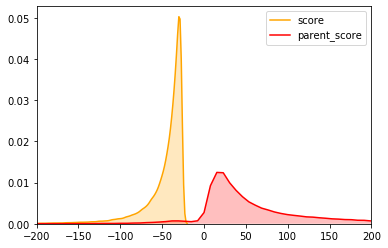

In [199]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.kdeplot(negjson["score"], shade=True, bw=2, color="orange", gridsize=2000)
sns.kdeplot(negjson["parent_score"], shade=True, bw=2, color="red", gridsize=2000)
plt.xlim(-200, 200)

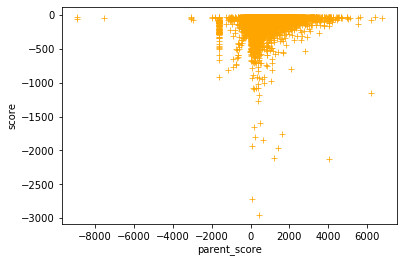

In [200]:
sns.scatterplot(x=negjson["parent_score"], y=negjson["score"], marker="+", color = "orange")

(-300, 500)

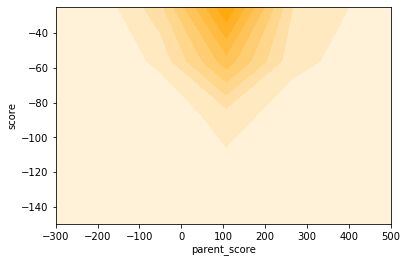

In [201]:
sns.kdeplot(negjson["parent_score"], negjson["score"], bw=10, shade=True, color = "orange")
plt.ylim(-150, -25)
plt.xlim(-300, 500)

In [202]:
negjson["abs_score"] = abs(negjson["score"])
negjson["abs_parent_score"] = abs(negjson["parent_score"])
negjson.corr()

,score,parent_score,text_len,parent_text_len,abs_score,abs_parent_score
score,1.000000,-0.098931,-0.016414,0.011744,-1.000000,-0.138251
parent_score,-0.098931,1.000000,0.009572,0.118021,0.098931,0.911137
text_len,-0.016414,0.009572,1.000000,0.146414,0.016414,0.004492
parent_text_len,0.011744,0.118021,0.146414,1.000000,-0.011744,0.123392
abs_score,-1.000000,0.098931,0.016414,-0.011744,1.000000,0.138251
abs_parent_score,-0.138251,0.911137,0.004492,0.123392,0.138251,1.000000


(-500, 4000)

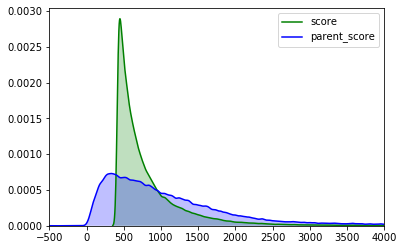

In [203]:
sns.kdeplot(posjson["score"], shade=True, bw=20, color="green", gridsize=2000)
sns.kdeplot(posjson["parent_score"], shade=True, bw=20, color="blue", gridsize=2000)
plt.xlim(-500,4000)

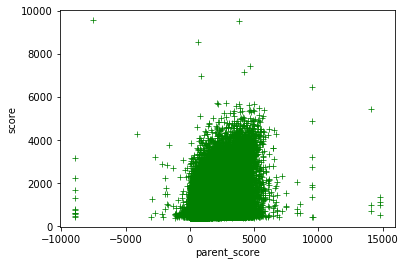

In [204]:
sns.scatterplot(x=posjson["parent_score"], y=posjson["score"], marker="+", color = "green")

(-200, 2000)

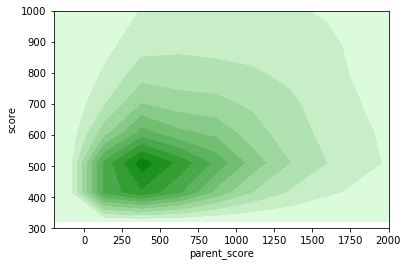

In [205]:
sns.kdeplot(posjson["parent_score"], posjson["score"], shade=True, color="green")
plt.ylim(300, 1000)
plt.xlim(-200, 2000)

In [206]:
posjson["abs_parent_score"] = abs(posjson["parent_score"])
posjson.corr()

,score,parent_score,text_len,parent_text_len,abs_parent_score
score,1.000000,0.493862,0.025013,0.025240,0.498738
parent_score,0.493862,1.000000,-0.023286,0.148703,0.985190
text_len,0.025013,-0.023286,1.000000,0.132724,-0.021691
parent_text_len,0.025240,0.148703,0.132724,1.000000,0.153932
abs_parent_score,0.498738,0.985190,-0.021691,0.153932,1.000000


In [216]:
pos_sub_freq = posjson.groupby("subreddit_name").count().sort_values(by="id", ascending=False)
pos_sub_freq = pos_sub_freq.drop(columns=["id", "parent_id", "text", "author", "parent_text", "parent_score", "parent_author", "abs_parent_score", "text_len", "parent_text_len"])

neg_sub_freq = negjson.groupby("subreddit_name").count().sort_values(by="id", ascending=False)
neg_sub_freq = neg_sub_freq.drop(columns=["id", "parent_id", "text", "author", "parent_text", "parent_score", "parent_author", "abs_parent_score", "text_len", "parent_text_len", "abs_score"])
neg_sub_freq.head(10)

,score
subreddit_name,
funny,15198
AskReddit,13125
pics,11669
gaming,8887
WTF,7949
politics,5178
IAmA,4940
videos,4558
todayilearned,4092


In [218]:
pos_sub_freq["subscribers"] = np.nan

for idx, row in pos_sub_freq.iterrows():
    try:
        t_subs = reddit.subreddit(idx).subscribers     
    except:
        t_subs = 0
    finally:
        pos_sub_freq.at[idx, "subscribers"] = int(t_subs)

neg_sub_freq["subscribers"] = np.nan
banned_or_removed = []

for idx, row in neg_sub_freq.iterrows():
    try:
        t_subs = reddit.subreddit(idx).subscribers     
    except:
        banned_or_removed.append(idx)
        t_subs = 0
    finally:
        neg_sub_freq.at[idx, "subscribers"] = int(t_subs)
        
print("could not look up subscriber count for banned/private/quarantined subreddits: ")
print(banned_or_removed)
neg_sub_freq.head(10)

could not look up subscriber count for banned/private/quarantined subreddits: 
['fatpeoplehate', 'watchpeopledie', 'CringeAnarchy', 'TheRedPill', 'Top_Comment_Judge', 'toosoon', 'CoonTown', 'StandUpComedians', 'metaredditcancer', 'Gore', 'incest', 'CandidFashionPolice', 'neckbeardstories', 'IDrawMuhammad', 'DateRape', 'DarkNetMarkets', 'opieandanthony', 'HealthProject', 'BlackFathers', 'video', 'starlets', 'doppelbangher', 'AmateurArchives', 'AngieVaronaLegal', '8chan', 'A858DE45F56D9BC9', 'theoffice', 'PicsOfDeadKids', 'TruePPD', 'myevilplan', 'TalesofFatHate']


,score,subscribers
subreddit_name,,
funny,15198,27573722.0
AskReddit,13125,25556126.0
pics,11669,23367380.0
gaming,8887,24415999.0
WTF,7949,5983877.0
politics,5178,5592959.0
IAmA,4940,19613099.0
videos,4558,21724038.0
todayilearned,4092,21874066.0


In [219]:
pos_sub_freq["subs_per_comment"] = pos_sub_freq["subscribers"] / pos_sub_freq["score"]
top_pos = pos_sub_freq[pos_sub_freq["subscribers"] > 5000].sort_values(by="subs_per_comment")

neg_sub_freq["subs_per_comment"] = neg_sub_freq["subscribers"] / neg_sub_freq["score"]
top_neg = neg_sub_freq[neg_sub_freq["subscribers"] > 5000].sort_values(by="subs_per_comment")
top_pos.head(10)

,score,subscribers,subs_per_comment
subreddit_name,,,
AskReddit,92431,25556126.0,276.488689
reddit.com,1742,829116.0,475.956372
WTF,7075,5983877.0,845.777668
Shitty_Watercolour,14,13855.0,989.642857
IAmA,14521,19613099.0,1350.671372
nfl,1215,1697202.0,1396.874074
Denver,68,116245.0,1709.485294
pics,11844,23367379.0,1972.929669
promos,6,11993.0,1998.833333


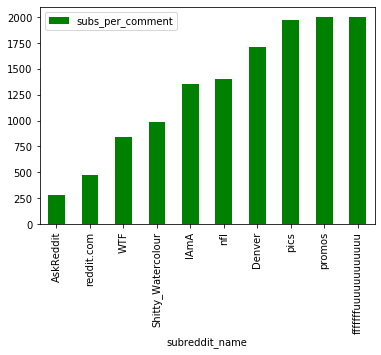

In [220]:
top_pos.head(10).plot.bar(y="subs_per_comment", color="green")

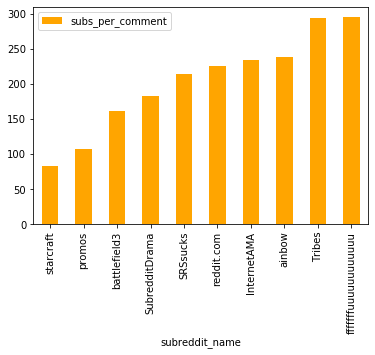

In [222]:
#NOTE y axis range
top_neg.head(10).plot.bar(y="subs_per_comment", color="orange")